In [1699]:
import numpy as np
import sqlite3 as sq
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import json
import matplotlib.text as mtext

from colors import Colors

%matplotlib inline

In [1700]:
connection = sq.connect("./measurements-all.db")
connection.row_factory = sq.Row

In [1701]:
def getQUICMedianTraceroutes(cacheWarming = False, protocol = "quic"):
    cacheCondition = "AND NOT d.cache_warming" if not cacheWarming else "AND d.cache_warming"
    sql = """
    SELECT
       d.id, d.ip, d.port, d.protocol, d.q_ui_c_handshake_duration as quic_handshake_duration, d.query_time, d.tcp_handshake_duration, d.tls_handshake_duration, d.total_time, d.q_ui_c_version
    FROM dns_measurements d
    WHERE d.protocol = '{}' {}
    AND d.id IN (SELECT DISTINCT(t.dns_measurement_id) FROM traceroutes t where t.dest_ip = t.hop_ip AND t.protocol = '{}');
    """.format(protocol, cacheCondition, protocol)
    handshake_duration = pd.read_sql_query(sql, connection)
    sql = """
    SELECT
    t.dns_measurement_id as id, dest_port as port, protocol, dest_ip, hop_ip, rtt
    FROM traceroutes t
    WHERE t.protocol = '{}' AND t.dest_ip = t.hop_ip
    """.format(protocol)
    rtts = pd.read_sql_query(sql, connection).groupby("id").sample(n = 1)
    return pd.merge(handshake_duration, rtts, on = ["id", "protocol", "port"])

def getQLogPandas():
    items = []
    with open("qlog-results.json", "r") as f:
        result = json.load(f)
    for ip, ports in result.items():
        for port, stats in ports.items():
            items.append({ "ip": ip, "port": int(port), "success": stats["success"], "retry": stats["retry"], "version_negotiation": stats["version_negotiation"] })
            
    return pd.DataFrame(items)

def calculateCDF(items):
    count, bins_count = np.histogram(items, bins="auto")

    pdf = count / sum(count)

    # using numpy np.cumsum to calculate the CDF
    # We can also find using the PDF values by looping and adding
    cdf = np.cumsum(pdf)
    return bins_count[1:], cdf

qlogResult = getQLogPandas()
quicTimes = getQUICMedianTraceroutes(protocol = "quic")
combined = pd.merge(quicTimes, qlogResult, on = ["ip", "port"])

def normalized(row):
    duration = row["quic_handshake_duration"]
    if not row["success"]:
        return duration / row["rtt"]
    if row["retry"]:
        duration -= row["rtt"]
    if row["version_negotiation"]:
        duration -= row["rtt"]
    return duration / row["rtt"]

combined["handshake/rtt"] = combined.apply(lambda row: row["quic_handshake_duration"]/row["rtt"], axis = 1)
combined["n(handshake/rtt)"] = combined.apply(normalized, axis = 1)
normalized_rtt = combined[combined["n(handshake/rtt)"].notna() & combined["success"]]

## Detailed Analysis Between Protocols

In [1702]:
def filterNA(df):
        return df[df["handshake/rtt"].notna()]["handshake/rtt"].tolist()
    
def addTLS(row):
    if row["tcp_handshake_duration"] and row["tls_handshake_duration"]:
        return (row["tcp_handshake_duration"] + row["tls_handshake_duration"])/row["rtt"]
    return np.nan

def addTLSHandshake(row):
    if row["tcp_handshake_duration"] and row["tls_handshake_duration"]:
        return (row["tcp_handshake_duration"] + row["tls_handshake_duration"])
    return np.nan
    
quicTimes = getQUICMedianTraceroutes(protocol = "quic")
tcpTimes = getQUICMedianTraceroutes(protocol = "tcp")
tlsTimes = getQUICMedianTraceroutes(protocol = "tls")
httpsTimes = getQUICMedianTraceroutes(protocol = "https")
quicTimes["handshake/rtt"] = quicTimes.apply(lambda row: row["quic_handshake_duration"]/row["rtt"], axis = 1)
tcpTimes["handshake/rtt"] = tcpTimes.apply(lambda row: row["tcp_handshake_duration"]/row["rtt"], axis = 1)
tlsTimes["handshake/rtt"] = tlsTimes.apply(addTLS, axis = 1)
tlsTimes["tls_handshake_duration"] = tlsTimes.apply(addTLSHandshake, axis = 1)
httpsTimes["handshake/rtt"] = httpsTimes.apply(addTLS, axis = 1)

In [1703]:
quicMedian = quicTimes.groupby(["ip"])["rtt"].median().div(1000000).reset_index(name = "quic_median")
tlsMedian = tlsTimes.groupby(["ip"])["rtt"].median().div(1000000).reset_index(name = "tls_median")
merged = pd.merge(quicMedian, tlsMedian, on = "ip")

In [1704]:
merged["diff"] = ((merged["quic_median"] - merged["tls_median"]) / merged["tls_median"]) * 100
# merged["diff"] = merged["diff"].div(1000000)

In [1705]:
merged["quic_median"].median()

161.794853

In [1706]:
ips_to_keep = merged#[merged["quic_median"] < 50]
ips_to_keep

,ip,quic_median,tls_median,diff
0,1.117.174.35,190.413951,191.856352,-0.751813
1,1.14.47.202,246.758335,246.546517,0.085914
2,1.15.141.251,250.919173,252.572745,-0.654691
3,1.15.174.179,187.349288,186.748535,0.321691
4,1.15.51.215,234.265401,235.195321,-0.395382
...,...,...,...,...
682,94.74.106.164,274.846684,275.196562,-0.127137
683,95.165.25.21,45.267629,45.099266,0.373318
684,95.179.134.211,21.624731,21.685775,-0.281493
685,95.179.180.194,21.712135,22.164997,-2.043140


In [1707]:
to_analyze_quic = normalized_rtt[normalized_rtt["ip"].isin(ips_to_keep["ip"])]
to_analyze_tls = tlsTimes[tlsTimes["ip"].isin(ips_to_keep["ip"]) & tlsTimes["tls_handshake_duration"].notna()]

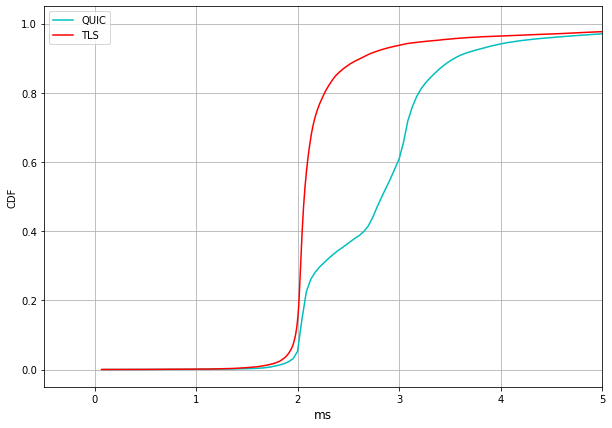

In [1708]:
cdfQUIC = calculateCDF(to_analyze_quic["handshake/rtt"])
cdfTLS = calculateCDF(to_analyze_tls["handshake/rtt"])

fig = plt.figure(figsize = (10, 7))
plt.plot(cdfQUIC[0], cdfQUIC[1], label="QUIC", color = Colors.quic)
plt.plot(cdfTLS[0], cdfTLS[1], label="TLS", color = Colors.tls)
plt.xlim([-0.5, 5])

plt.xlabel("ms", fontsize = 12)
plt.ylabel("CDF")

plt.legend()
plt.grid()

# plt.savefig("figures/resolve_time_cdf.pdf", bbox_inches='tight')
plt.show()

In [1709]:
to_analyze_quic["handshake/rtt"].median()

2.8282014886593814

In [1710]:
additional_stats = pd.read_csv("qlog-stats.csv", index_col = ["ip"])
to_analyze_with_additional = pd.merge(to_analyze_quic, additional_stats, on = ["ip", "port"])
to_analyze_with_additional["rtt_x"] = to_analyze_with_additional["rtt_x"].div(1000000)
to_analyze_with_additional["rtt_diff"] = (to_analyze_with_additional["rtt_x"] - to_analyze_with_additional["rtt_y"]).abs() / to_analyze_with_additional["rtt_x"] 

result_filtered = to_analyze_with_additional[to_analyze_with_additional["rtt_diff"] <= 0.1]
result_filtered = result_filtered.fillna(0)
# result_filtered = result_filtered.groupby(["ip", "port"]).median().reset_index()

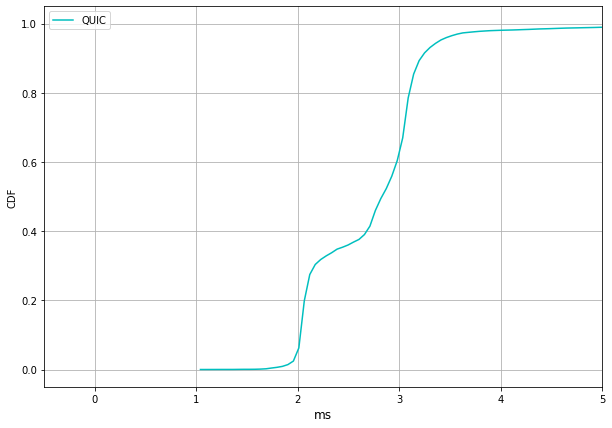

In [1711]:
cdfQUIC = calculateCDF(result_filtered["handshake/rtt"])

fig = plt.figure(figsize = (10, 7))
plt.plot(cdfQUIC[0], cdfQUIC[1], label="QUIC", color = Colors.quic)
plt.xlim([-0.5, 5])

plt.xlabel("ms", fontsize = 12)
plt.ylabel("CDF")

plt.legend()
plt.grid()

plt.show()

In [1712]:
quant_25 = result_filtered["rtt_x"].quantile(0.25)
quant_50 = result_filtered["rtt_x"].quantile(0.5)
quant_75 = result_filtered["rtt_x"].quantile(0.75)

In [1713]:
result_25 = result_filtered[result_filtered["rtt_x"] <= quant_25]
result_50 = result_filtered[(result_filtered["rtt_x"] > quant_25) & (result_filtered["rtt_x"] <= quant_50)]
result_75 = result_filtered[(result_filtered["rtt_x"] > quant_50) & (result_filtered["rtt_x"] <= quant_75)]
result_100 = result_filtered[result_filtered["rtt_x"] > quant_75]
print(len(result_25.index), len(result_50.index), len(result_75.index), len(result_100.index))

11889 11888 11888 11888


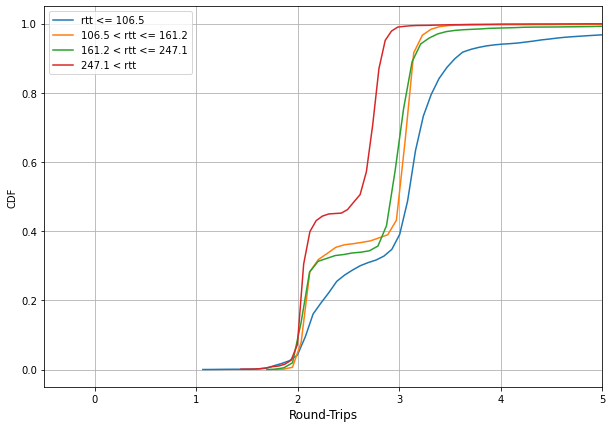

In [1714]:
def plotCDF(cdf, label):
    plt.plot(cdf[0], cdf[1], label = label)

cdf_25 = calculateCDF(result_25["handshake/rtt"])
cdf_50 = calculateCDF(result_50["handshake/rtt"])
cdf_75 = calculateCDF(result_75["handshake/rtt"])
cdf_100 = calculateCDF(result_100["handshake/rtt"])

fig = plt.figure(figsize = (10, 7))

plotCDF(cdf_25, "rtt <= {:.1f}".format(quant_25))
plotCDF(cdf_50, "{:.1f} < rtt <= {:.1f}".format(quant_25, quant_50))
plotCDF(cdf_75, "{:.1f} < rtt <= {:.1f}".format(quant_50, quant_75))
plotCDF(cdf_100, "{:.1f} < rtt".format(quant_75))
plt.xlim([-0.5, 5])

plt.xlabel("Round-Trips", fontsize = 12)
plt.ylabel("CDF")

plt.legend()
plt.grid()

plt.savefig("figures/handshake_analysis_groups_cdf.pdf", bbox_inches='tight')
plt.show()

In [1735]:
def plotTotal(key, x_title = "Packets"):
    fig = plt.figure(figsize = (9, 4))
    ax = fig.add_subplot(111)
    commonConfig = {
        "bins": range(0, 50),
        "rwidth": 1,
        "cumulative": 1,
        "histtype": "step",
        "linewidth": 2,
        "density": True
    }
    result_25[key].plot.hist(label = "rtt <= {:.1f}".format(quant_25), **commonConfig)
    result_50[key].plot.hist(label = "{:.1f} < rtt <= {:.1f}".format(quant_25, quant_50), **commonConfig)
    result_75[key].plot.hist(label = "{:.1f} < rtt <= {:.1f}".format(quant_50, quant_75), **commonConfig)
    result_100[key].plot.hist(label = "{:.1f} < rtt".format(quant_75), **commonConfig)
    
    ax.set_xlabel(x_title)
    ax.set_axisbelow(True)
    ax.grid()
    
    ax.set_xticks(np.arange(0, 50, 1))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xlim([-0.5, 15])
    
    ax.legend(loc = "lower right")
    plt.savefig("figures/handshake_analysis_group_{}_hist.pdf".format(key), bbox_inches='tight')
    return ax

In [1716]:
def plot(df, key, ax, title, x_title = "Packets", quantile = 0.5):
    LOWER_LIMIT = df["handshake/rtt"].quantile(quantile)
    UPPER_LIMIT = df["handshake/rtt"].quantile(1 - quantile)
    
    commonConfig = {
        "bins": range(0, 50),
        "rwidth": 1,
        "cumulative": 1,
        "histtype": "step",
        "linewidth": 2,
        "alpha": 0.8,
        "density": True,
        "ax": ax
    }
    
    df[df["handshake/rtt"] <= LOWER_LIMIT][key].plot.hist(label = "<= {:.2f}".format(LOWER_LIMIT), **commonConfig)
    df[df["handshake/rtt"] > UPPER_LIMIT][key].plot.hist(label = "> {:.2f}".format(UPPER_LIMIT), **commonConfig)
    
    ax.set_xticks(np.arange(0, 50, 1))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xlim([-0.5, 15])
    
    ax.set_title(title)
    
    ax.set_xlabel(x_title)
    ax.set_axisbelow(True)
    ax.legend(loc = "lower right")
    ax.grid()
    
    return ax

def plotGroup(key, x_title = "Packets"):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (10, 15))
    fig.tight_layout()
    plt.subplots_adjust(hspace = 0.3)
    quantile = 0.5
    plot(result_25, key, ax1, title = "rtt <= {:.1f}".format(quant_25), quantile = quantile, x_title = x_title)
    plot(result_50, key, ax2, title = "{:.1f} < rtt <= {:.1f}".format(quant_25, quant_50), quantile = quantile, x_title = x_title)
    plot(result_75, key, ax3, title = "{:.1f} < rtt <= {:.1f}".format(quant_50, quant_75), quantile = quantile, x_title = x_title)
    plot(result_100, key, ax4, title = "{:.1f} < rtt".format(quant_75), quantile = quantile, x_title = x_title)
    plt.savefig("figures/handshake_analysis_{}_hist.pdf".format(key), bbox_inches='tight')

## Group Comparison

#### Total Received

<AxesSubplot:xlabel='Packets', ylabel='Frequency'>

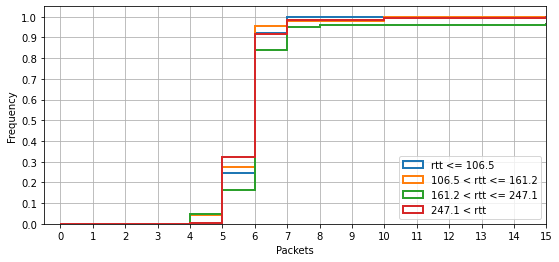

In [1736]:
plotTotal("total_received")

#### Handshake Received

<AxesSubplot:xlabel='Packets', ylabel='Frequency'>

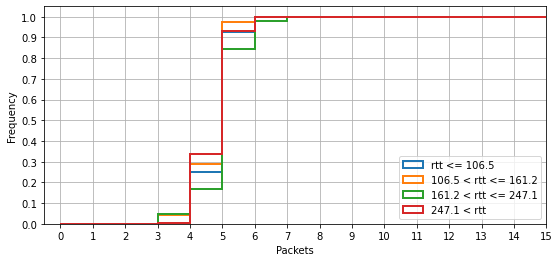

In [1737]:
plotTotal("handshake_received")

#### Total Sent

<AxesSubplot:xlabel='Packets', ylabel='Frequency'>

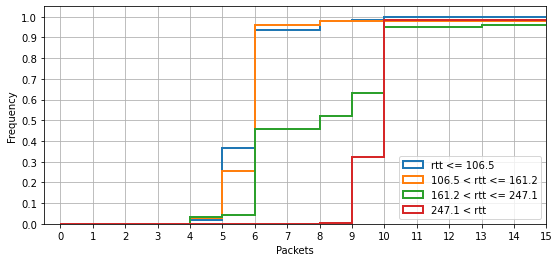

In [1738]:
plotTotal("total_sent")

#### Initial Until Retry

(-0.5, 5.0)

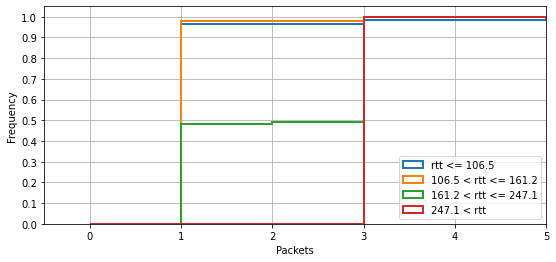

In [1739]:
ax = plotTotal("initial_sent_until_retry")
ax.set_xlim([-0.5, 5])

#### Packet Dropped

(-0.5, 5.0)

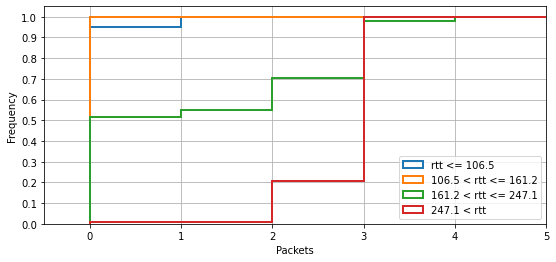

In [1740]:
ax = plotTotal("packet_dropped")
ax.set_xlim([-0.5, 5])

#### PTO Expired

(-0.5, 5.0)

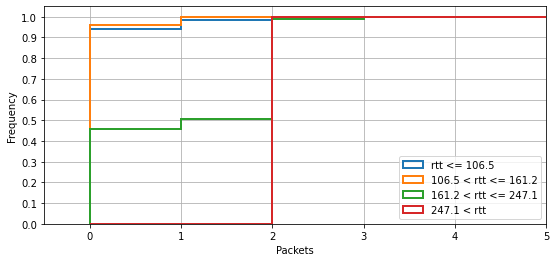

In [1741]:
ax = plotTotal("pto_expired")
ax.set_xlim([-0.5, 5])

#### Coalesced Received

<AxesSubplot:xlabel='UDP Datagrams', ylabel='Frequency'>

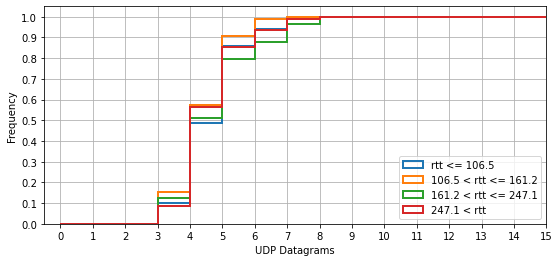

In [1742]:
plotTotal("coalesced_received", x_title = "UDP Datagrams")

#### Coalesced Sent

<AxesSubplot:xlabel='UDP Datagrams', ylabel='Frequency'>

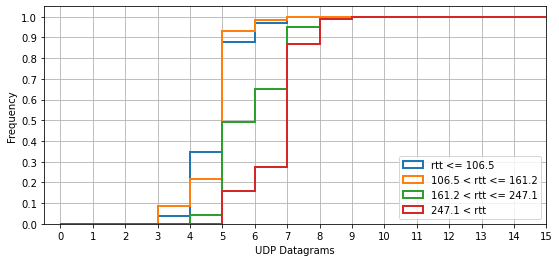

In [1743]:
plotTotal("coalesced_sent", x_title = "UDP Datagrams")

## Group RTT Split

### Total Received

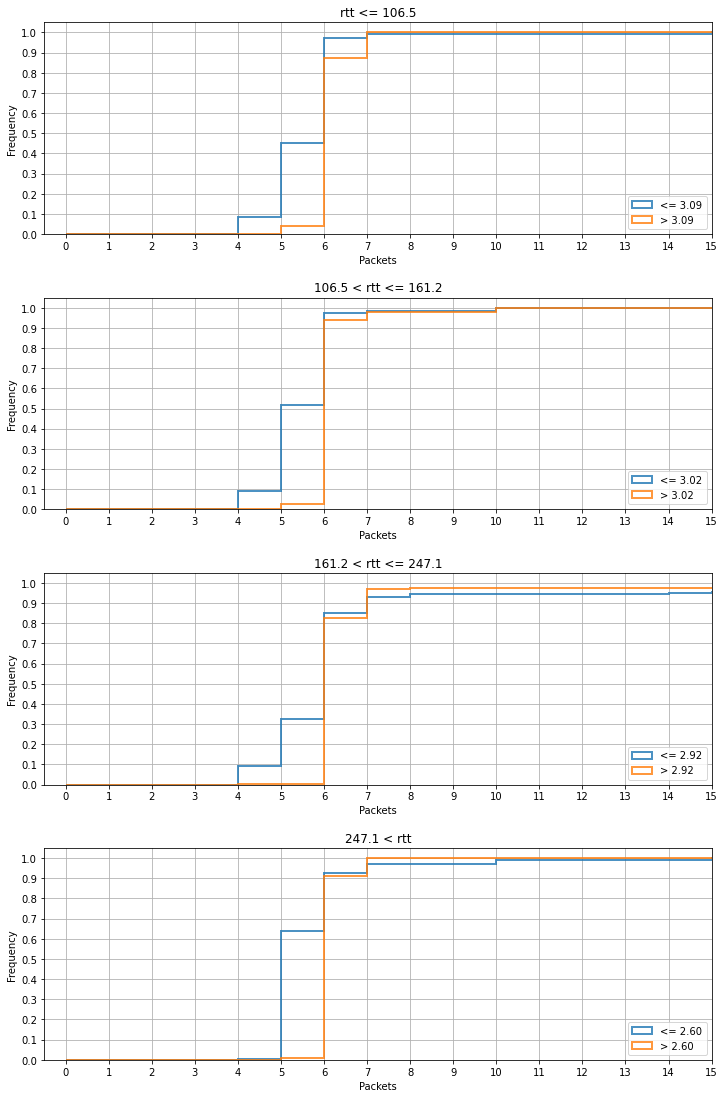

In [1725]:
plotGroup("total_received")

### Handshake Received

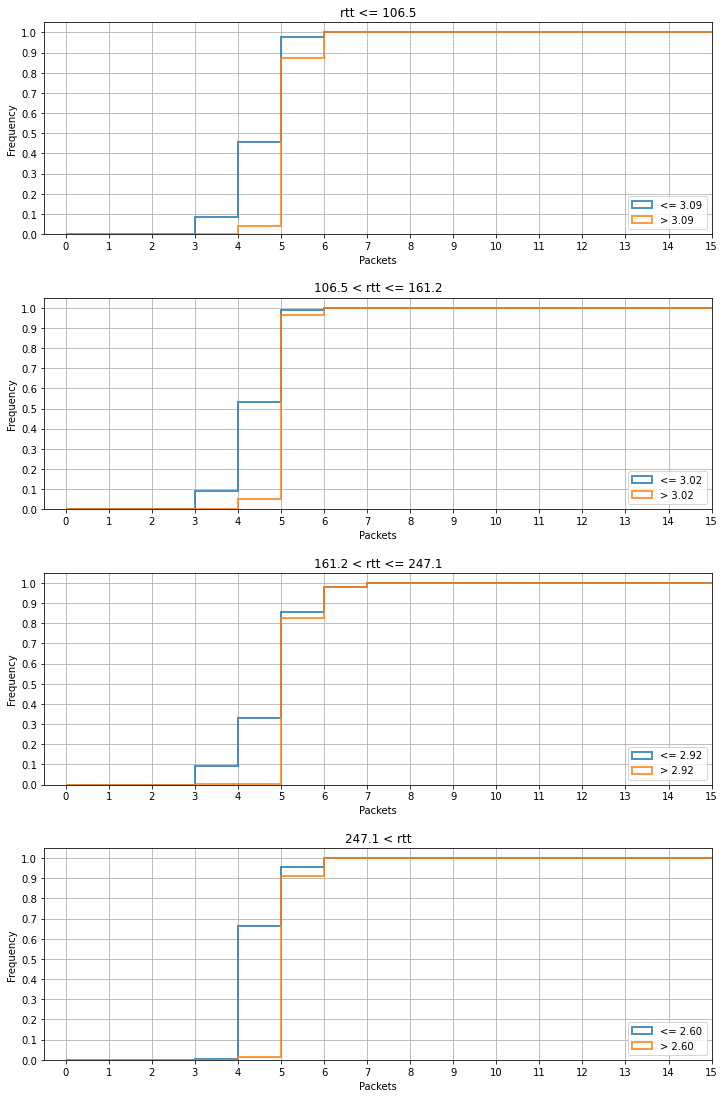

In [1726]:
plotGroup("handshake_received")

### Total Sent

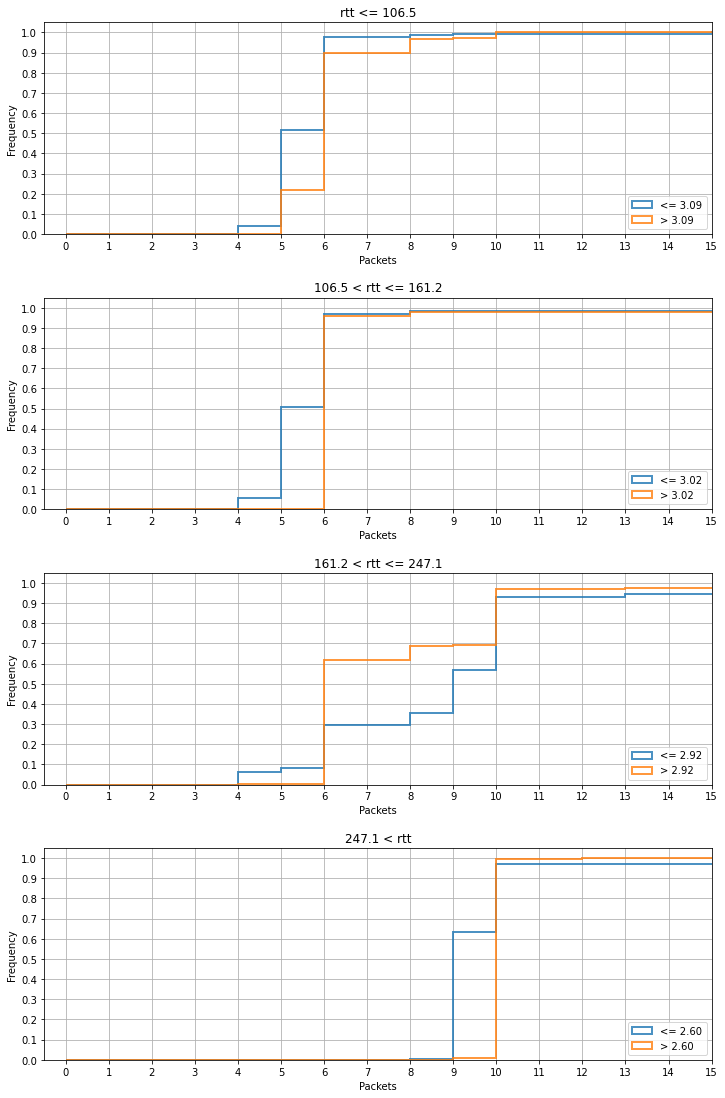

In [1727]:
plotGroup("total_sent")

### Packet Dropped

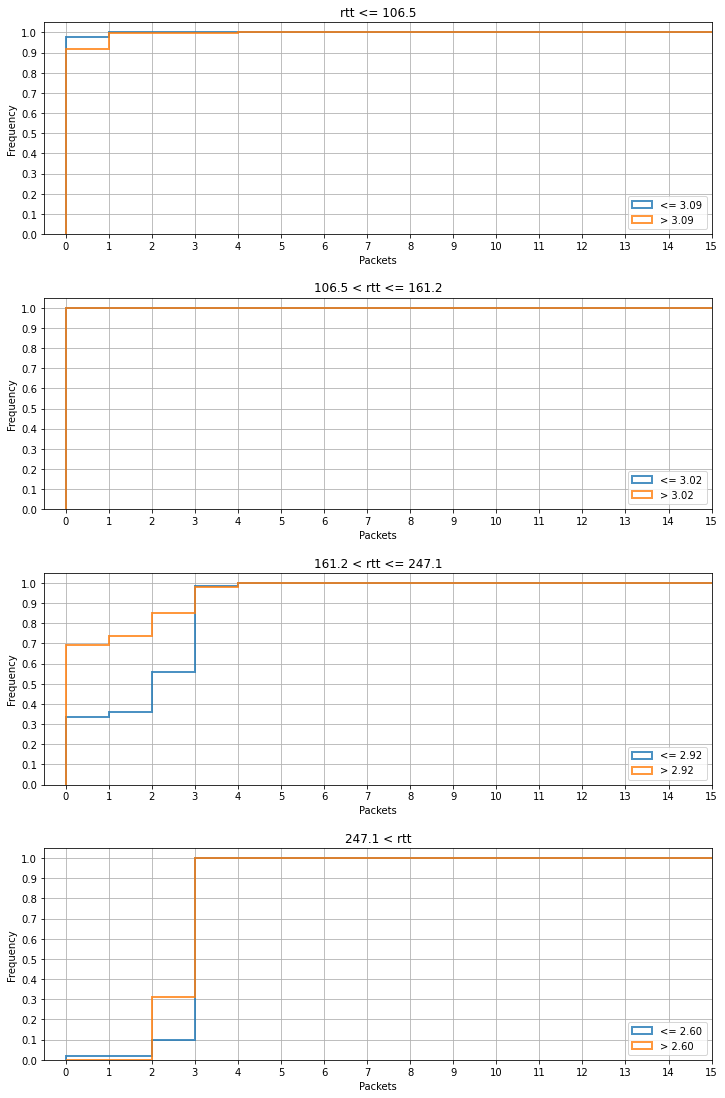

In [1728]:
plotGroup("packet_dropped")

### Initial until Retry

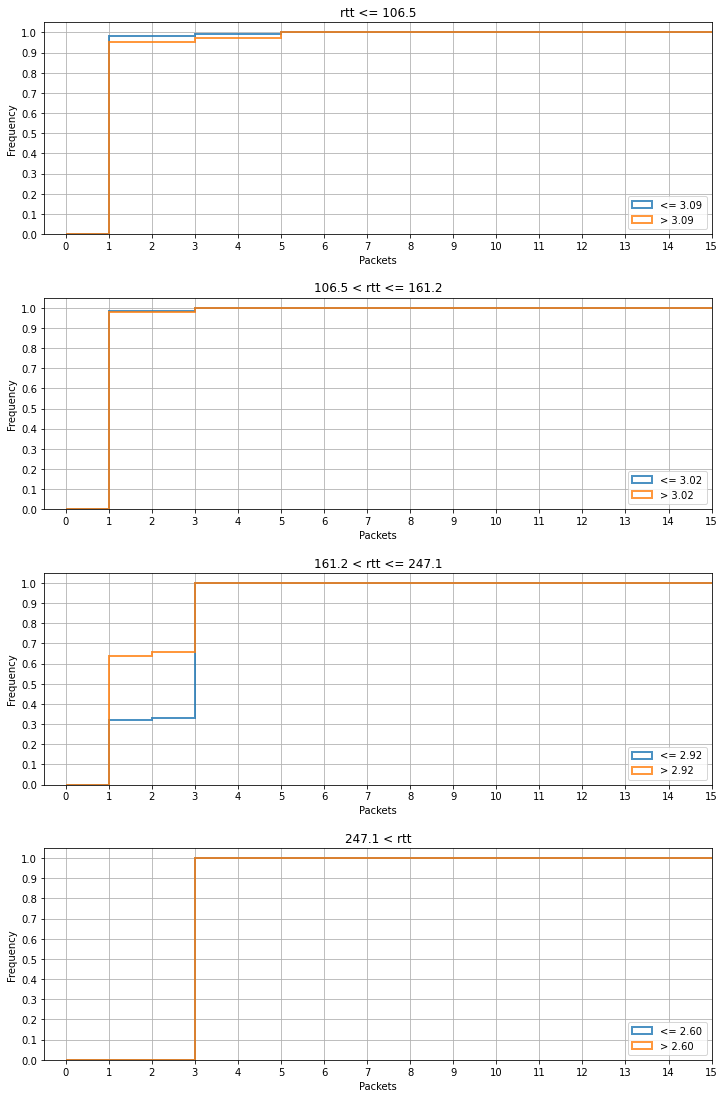

In [1729]:
plotGroup("initial_sent_until_retry")

### PTO Expired

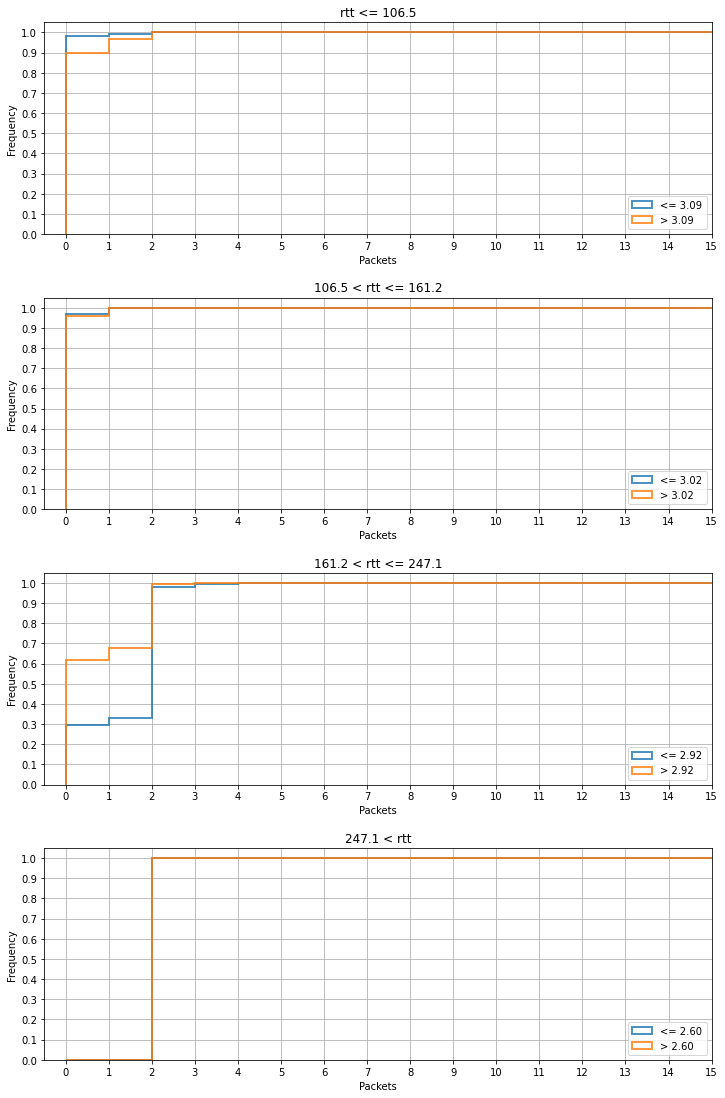

In [1730]:
plotGroup("pto_expired")

### Coalesced Received

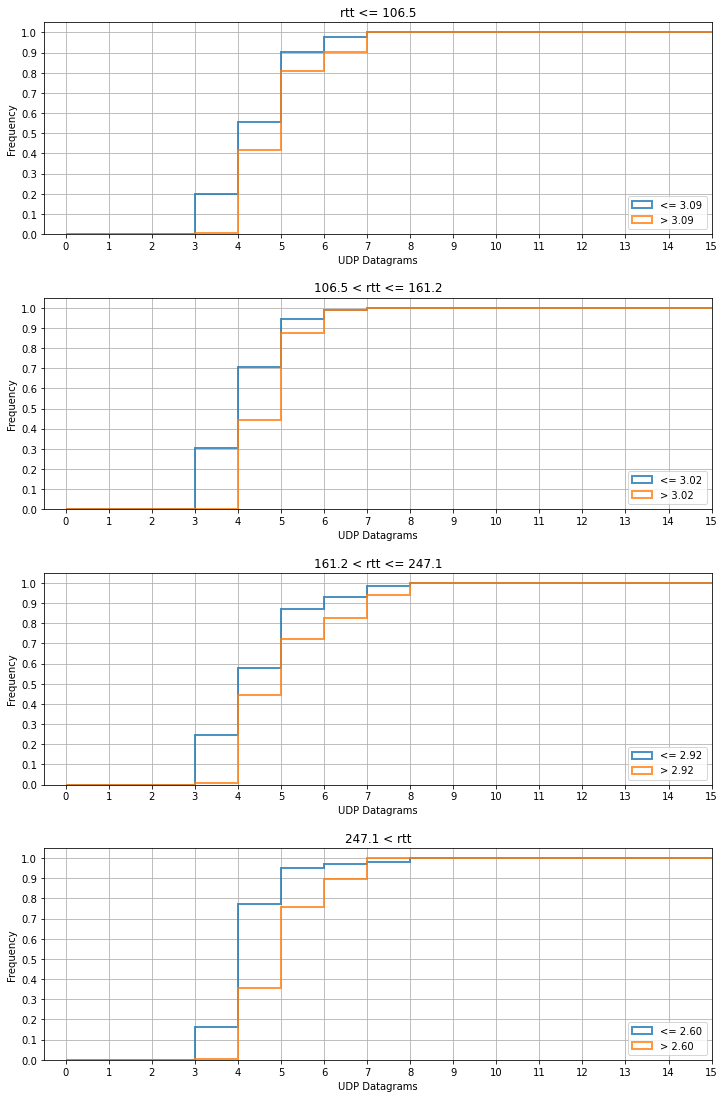

In [1731]:
plotGroup("coalesced_received", x_title = "UDP Datagrams")

### Coalesced Sent

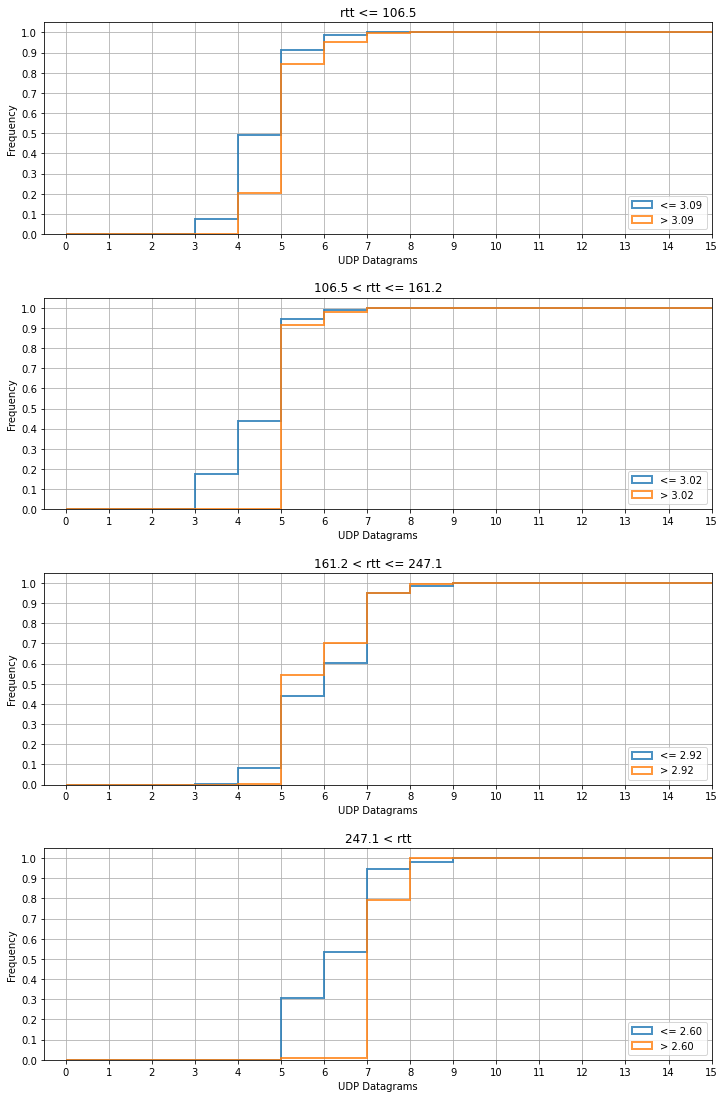

In [1732]:
plotGroup("coalesced_sent", x_title = "UDP Datagrams")